In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
def aws():
    try:
        connection = psycopg2.connect(user='postgres',
                                      password='password',
                                      host='almau-students.cmwfjvlei66t.eu-central-1.rds.amazonaws.com',
                                      port='5432',
                                      database='postgres')
        print('connected')
    except(Exception, psycopg2.Error) as error:
        connection = ''
        print(error)
    return connection

In [3]:
%time df = pd.read_sql_query('select * from flight_delays_1', aws()) #Подключка к удаленному серверу
#df = pd.read_csv('flight_delays 1.csv', header = 0, sep=',')

connected
Wall time: 8.87 s


In [4]:
df = df.rename({'month': 'Month', 'dayofmonth': 'DayofMonth', 'dayofweek': 'DayOfWeek', 'deptime': 'DepTime', 'uniquecarrier': 'UniqueCarrier', 'origin': 'Origin',
                       'dest': 'Dest', 'distance': 'Distance', 'dep_delayed_15min': 'dep_delayed_15min'}, axis=1)
#Хедер переименовали

In [5]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [6]:
def do_norm_table():
    df['Month']= df['Month'].apply(lambda x: x.split('-')[1])
    df['Month'] = df['Month'].apply(int)
    df['DayofMonth'] = df['DayofMonth'].apply(lambda x: x.split('-')[1])
    df['DayofMonth'] = df['DayofMonth'].apply(int)
    df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: x.split('-')[1])
    df['DayOfWeek'] = df['DayOfWeek'].apply(int)
do_norm_table() #Делаем данные в нормальный вид
def no_yes(val):
    if 'Y' in val:
        return 1
    else:
        return 0
df['dep_delayed_15min'] = df['dep_delayed_15min'].apply(lambda x: no_yes(x))  #Меняем задержу с (Y и N) на (1 и 0)

df_delay = df[df.dep_delayed_15min==1]
df_nodelay = df[df['dep_delayed_15min']==0]
delays = len(df_delay)
nodelays = len(df_nodelay)
airlines = sorted(df.UniqueCarrier.unique())
origins= sorted(df.Origin.unique(), reverse=True)
destinations= sorted(df.Dest.unique(), reverse=True)
numAirlines= len(airlines)
numOrigins= len(origins)
numDestinations = len(destinations)
minDist = df.Distance.min()
maxDist = df.Distance.max()

#Переменные Для графиков
Ycol = ["red"] #Цвет задержали
Ncol = ["black"] #Цвет не задержали
plt.rcParams['figure.figsize'] = (10,6) #Размер графиков

In [7]:
print('Количество задержек - ',delays)
print('Количество без задержек - ',nodelays)
print('Список Кодов аэропорта ИАТА - ',airlines)
#print('Список эропортов откуда был вылет - ',origins)
# print('Место назначения - ',destinations) # ПОВТОРЯЕТ origins
print('Количество Авиакомпаний - ',numAirlines)
print('Количество аэропортов откуда был вылет - ',numOrigins)
print('Количество аэропортов куда был вылет - ',numDestinations)
print('Минимальная дистранция в км - ',minDist)
print('Максимальная дистранция в км - ',maxDist)

Количество задержек -  19044
Количество без задержек -  80956
Список Кодов аэропорта ИАТА -  ['AA', 'AQ', 'AS', 'B6', 'CO', 'DH', 'DL', 'EV', 'F9', 'FL', 'HA', 'HP', 'MQ', 'NW', 'OH', 'OO', 'TZ', 'UA', 'US', 'WN', 'XE', 'YV']
Количество Авиакомпаний -  22
Количество аэропортов откуда был вылет -  289
Количество аэропортов куда был вылет -  289
Минимальная дистранция в км -  30
Максимальная дистранция в км -  4962


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null int64
DayofMonth           100000 non-null int64
DayOfWeek            100000 non-null int64
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null int64
dtypes: int64(6), object(3)
memory usage: 6.9+ MB


Text(0.5, 1.0, 'Авиакомпании')

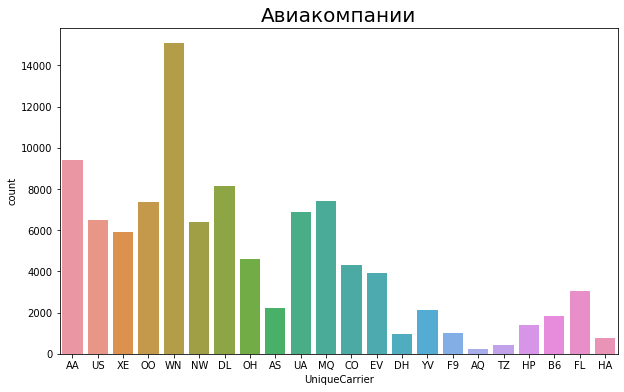

In [9]:
sns.countplot(x='UniqueCarrier', data=df)
ax = plt.gca()
ax.set_title("Авиакомпании",fontsize=20)

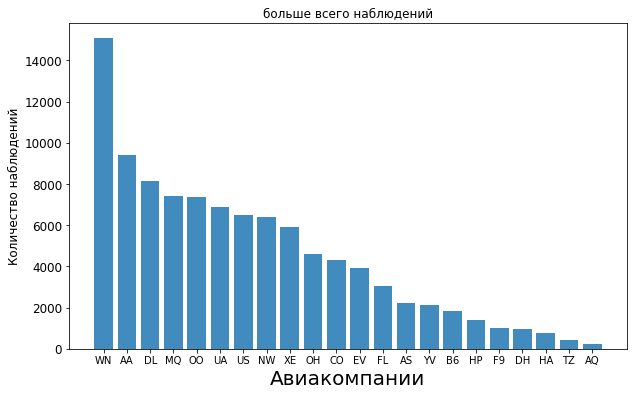

In [10]:
def dict_sort(my_dict):
    keys = []
    values = []
    my_dict = sorted(my_dict.items(), key=lambda x:x[1], reverse=True)
    for k, v in my_dict:
        keys.append(k)
        values.append(v)
    return (keys,values)
count = pd.value_counts(df['UniqueCarrier'].values, sort=True)
keys, values = dict_sort(dict(count))    
TOP = len(keys)
plt.title('больше всего наблюдений', fontsize=12)
plt.bar(np.arange(TOP), values, alpha=0.85)
plt.xticks(np.arange(TOP), keys, rotation=0, fontsize=10)
plt.yticks(fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.xlabel("Авиакомпании",fontsize=20)
plt.show()

In [11]:
a = df.corr()

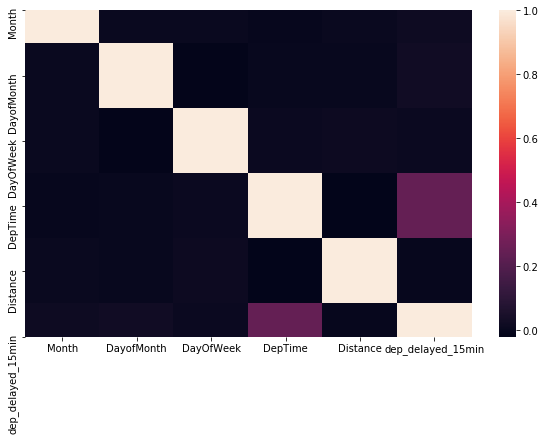

In [12]:
sns.heatmap(a)

In [13]:
dfix = df[df['dep_delayed_15min'] == 1]
dfix[['UniqueCarrier','dep_delayed_15min']].groupby(['UniqueCarrier']).count()

,dep_delayed_15min
UniqueCarrier,
AA,1770
AQ,18
AS,541
B6,393
CO,788
DH,156
DL,1373
EV,1082
F9,156


In [14]:
df.groupby(['UniqueCarrier'])['dep_delayed_15min'].agg([np.mean]).sort_values(by='mean', ascending=False).T * 100

UniqueCarrier,EV,AS,FL,YV,B6,WN,MQ,UA,AA,CO,...,OO,DL,NW,US,DH,F9,TZ,HP,AQ,HA
mean,27.531807,24.347435,24.218493,22.462406,21.381937,21.343323,19.454521,19.226294,18.793799,18.181818,...,17.280108,16.892224,16.789005,16.738661,16.149068,15.506958,14.349776,14.223512,7.692308,4.330709


Text(0.5, 1.0, 'Дни недели')

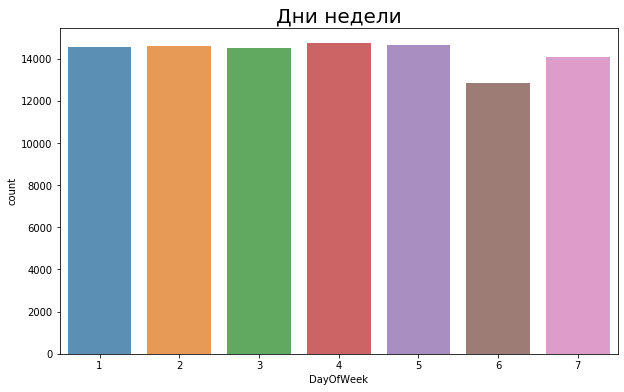

In [15]:
sns.countplot(x="DayOfWeek",data=df, alpha=0.8)
ax = plt.gca()
ax.set_title("Дни недели",fontsize=20)

Процентаж задержания рейсов: 0 - без задержек, 1 - задержали
0    81.0
1    19.0
Name: dep_delayed_15min, dtype: float64


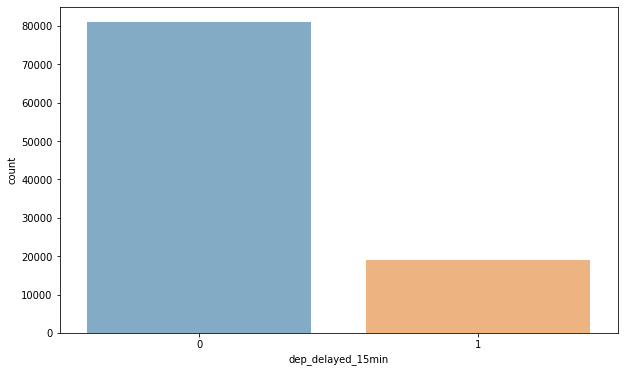

In [16]:
sns.countplot(x="dep_delayed_15min",data=df, alpha=0.6)
procentage = round(df['dep_delayed_15min'].value_counts() * 100 / len(df),1)
print('Процентаж задержания рейсов: 0 - без задержек, 1 - задержали')
print(procentage)

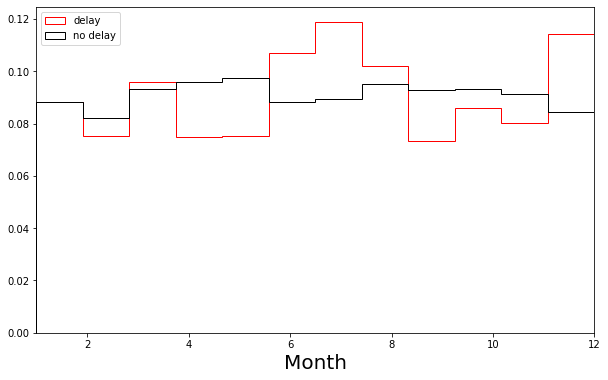

In [17]:
plt.hist(df_delay.Month,bins=12, color=Ycol,histtype="step",label="delay",density=True)
plt.hist(df_nodelay.Month,bins=12, color=Ncol,histtype="step",label="no delay",density=True)
plt.xlabel("Month", fontsize=20)
plt.xlim([1,12])
plt.legend(prop={'size': 10},loc="upper left")

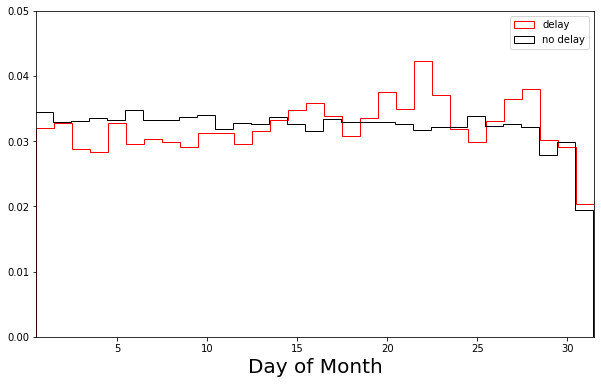

In [18]:
plt.hist(df_delay.DayofMonth,bins=31,range=[0.5,31.5],color=Ycol,histtype="step",label="delay",density=True)
plt.hist(df_nodelay.DayofMonth,bins=31,range=[0.4,31.4],color=Ncol,histtype="step",label="no delay",density=True)
plt.xlabel("Day of Month", fontsize=20)
plt.xlim(0.5,31.5)
plt.ylim(0.0,0.05)
plt.legend(prop={'size': 10},loc="upper right")

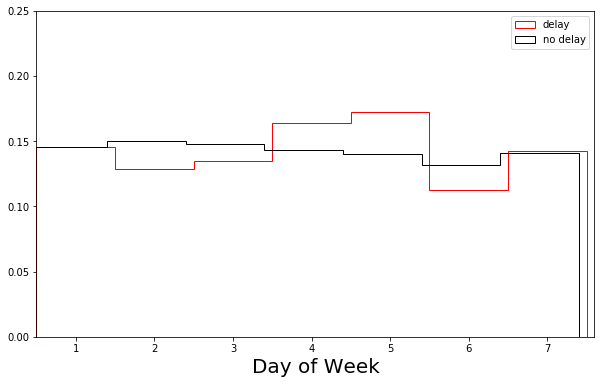

In [19]:
plt.hist(df_delay.DayOfWeek,bins=7,range=[0.5,7.5], color=Ycol,histtype="step",label="delay",density=True)
plt.hist(df_nodelay.DayOfWeek,bins=7,range=[0.4,7.4], color=Ncol,histtype="step",label="no delay",density=True)
plt.xlabel("Day of Week", fontsize=20)
plt.xlim(0.5,7.6)
plt.ylim(0.0,0.25)
plt.legend(prop={'size': 10},loc="upper right")

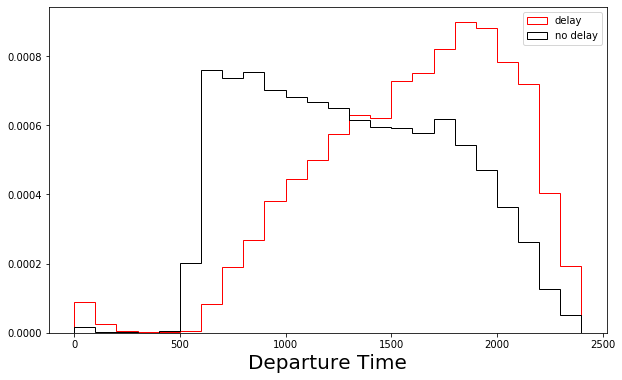

In [20]:
plt.hist(df_delay.DepTime,bins=24,range=[0,2400],color=Ycol,histtype="step",label="delay",density=True)
plt.hist(df_nodelay.DepTime,bins=24,range=[0,2400],color=Ncol,histtype="step",label="no delay",density=True)
plt.xlabel("Departure Time", fontsize=20)
plt.legend(prop={'size': 10},loc="upper right")

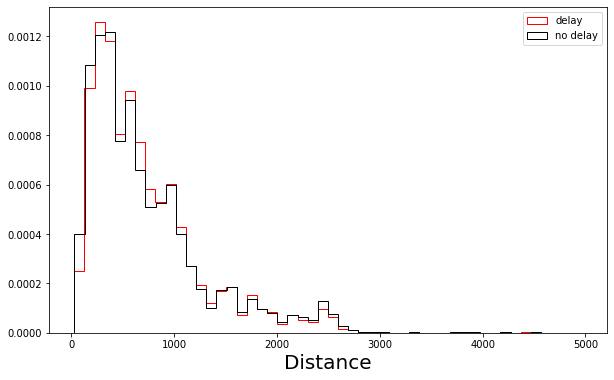

In [21]:
plt.hist(df_delay.Distance,bins=50, color=Ycol,histtype="step",label="delay",density=True)
plt.hist(df_nodelay.Distance,bins=50, color=Ncol,histtype="step",label="no delay",density=True)
plt.xlabel("Distance", fontsize=20)
plt.legend(prop={'size': 10},loc="upper right")

In [22]:
df2 = pd.get_dummies(df,drop_first=False)
print(df2.describe(include="all"))

               Month     DayofMonth     DayOfWeek        DepTime  \
count  100000.000000  100000.000000  100000.00000  100000.000000   
mean        6.537640      15.703850       3.95183    1341.523880   
std         3.413447       8.793931       1.99164     476.378445   
min         1.000000       1.000000       1.00000       1.000000   
25%         4.000000       8.000000       2.00000     931.000000   
50%         7.000000      16.000000       4.00000    1330.000000   
75%         9.000000      23.000000       6.00000    1733.000000   
max        12.000000      31.000000       7.00000    2534.000000   

           Distance  dep_delayed_15min  UniqueCarrier_AA  UniqueCarrier_AQ  \
count  100000.00000       100000.00000      100000.00000     100000.000000   
mean      729.39716            0.19044           0.09418          0.002340   
std       574.61686            0.39265           0.29208          0.048317   
min        30.00000            0.00000           0.00000          0.000000 

In [23]:
# Из пандас датафрейма превращает в нумпай матрицу
features = df2.columns.values.tolist()
features.remove("dep_delayed_15min")
X = df2.as_matrix(columns=features)
Y = np.array([int(i) for i in df2["dep_delayed_15min"].tolist()])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print("Training set size: %i, test set size: %i, total: %i" %(len(y_train),len(y_test),len(Y)))

Training set size: 70000, test set size: 30000, total: 100000


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(n_estimators=50, max_depth=20)

%time rf2.fit(X_train, y_train)

print("Средняя точность на Тренировочных данных: %s" %rf2.score(X_train, y_train))
print("Средняя точность на Тестовых данных: %s" %rf2.score(X_test, y_test))

Wall time: 38.7 s
Средняя точность на Тренировочных данных: 0.8100428571428572
Средняя точность на Тестовых данных: 0.8087333333333333


Количество тестовых строк = 30000
Количество тестовых строк, где dep_delayed_15min равен единице = 5740
Задержек в Training: 13304, Без задержек: 56696
Задержек в Testing: 5740, Без задержек: 24260


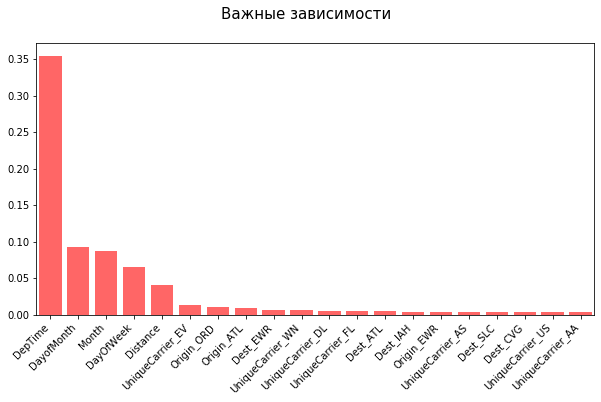

In [25]:
print('Количество тестовых строк = %i' %len(y_test))
print('Количество тестовых строк, где dep_delayed_15min равен единице = %i' %(len([val for val in y_test if val])))

y_test_pred    = [p2 for [p1,p2] in rf2.predict_proba(X_test)]
y_train_pred   = [p2 for [p1,p2] in rf2.predict_proba(X_train)]

importances = rf2.feature_importances_
indices     = np.argsort(importances)[::-1]
n_features  = min(20,indices.size)
bins        = np.arange(n_features)
x_labels    = np.array(features)[indices][0:n_features]

fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plt.suptitle("Важные зависимости", fontsize=15)
axes.bar(bins, importances[indices][:n_features], color="red", alpha=0.6)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45.)
axes.set_xlim([-0.5,bins.size-0.5])


y_train_pred_1 = [pred for (pred,truth) in zip(y_train_pred,y_train) if truth==1]
y_train_pred_0 = [pred for (pred,truth) in zip(y_train_pred,y_train) if truth==0]
y_test_pred_1  = [pred for (pred,truth) in zip(y_test_pred,y_test) if truth==1]
y_test_pred_0  = [pred for (pred,truth) in zip(y_test_pred,y_test) if truth==0]
print("Задержек в Training: %i, Без задержек: %i" %(len(y_train_pred_1),len(y_train_pred_0)))
print("Задержек в Testing: %i, Без задержек: %i" %(len(y_test_pred_1),len(y_test_pred_0)))

In [64]:
y_train_pred_1

[0.25332288152087623,
 0.2133653838469666,
 0.1580194338643254,
 0.2148249576403228,
 0.2570470926792238,
 0.21201656653152873,
 0.222244236894579,
 0.3300632629462465,
 0.3273286563501132,
 0.26498436950954757,
 0.2796996854738717,
 0.13942786486610242,
 0.3379977146518191,
 0.20199813398890676,
 0.37842817038084803,
 0.2521498833322397,
 0.2630653348101045,
 0.3753094707350392,
 0.272949297303826,
 0.33286664902153207,
 0.1916937777441258,
 0.3174459528766265,
 0.21982905701101477,
 0.38477725051817485,
 0.2365811853140997,
 0.15827990556919033,
 0.27148324639352345,
 0.23461739228044012,
 0.25153419276781486,
 0.21633022642315183,
 0.252833358271095,
 0.18572122117611276,
 0.2058094735278882,
 0.32356818486805544,
 0.2303758318819933,
 0.22581047830475065,
 0.21255432856613482,
 0.22840847873209685,
 0.23588041850724006,
 0.1652991668532794,
 0.24945977113118295,
 0.21721762913877163,
 0.19696697468375401,
 0.17603724325807196,
 0.30929746040781053,
 0.23303066964334415,
 0.16452003

Text(0.5, 1.0, 'Test')

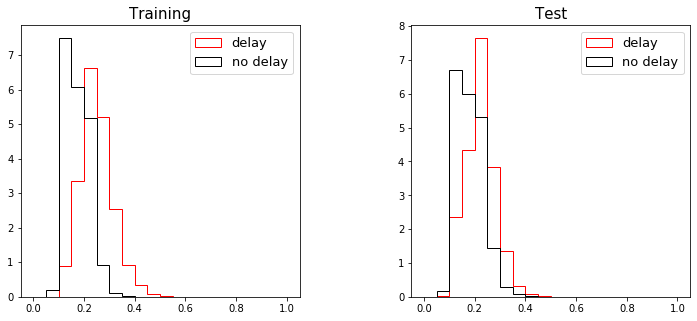

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.subplots_adjust(wspace=0.40)
axes[0].hist(y_train_pred_1, bins=20, range=[0.0,1.0], color=Ycol, histtype="step", label="delay", density=True)
axes[0].hist(y_train_pred_0, bins=20, range=[0.0,1.0], color=Ncol, histtype="step", label="no delay", density=True)
axes[0].legend(prop={'size': 13})
axes[0].set_title("Training", fontsize=15)
axes[1].hist(y_test_pred_1, bins=20, range=[0.0,1.0], color=Ycol, histtype="step", label="delay", density=True)
axes[1].hist(y_test_pred_0, bins=20, range=[0.0,1.0], color=Ncol, histtype="step", label="no delay", density=True)
axes[1].legend(prop={'size': 13})
axes[1].set_title("Test", fontsize=15)

In [28]:
Y = df['dep_delayed_15min']

In [29]:
X = df[['DepTime','Distance', 'DayOfWeek', 'DayofMonth']]

In [30]:
model = LinearRegression()

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [32]:
%time model.fit(X_train,Y_train)

Wall time: 1.48 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
model.coef_

array([2.00920665e-04, 2.41437782e-06, 9.69190853e-04, 1.27206966e-03])

In [34]:
print('Средняя абсолютная ошибка:',round(metrics.mean_absolute_error(model.predict(X_test),Y_test),4))
print('Среднеквадратичная ошибка:',round(metrics.mean_squared_error(model.predict(X_test),Y_test),4))

Средняя абсолютная ошибка: 0.2905
Среднеквадратичная ошибка: 0.1452


In [35]:
# metrics.mean_squared_log_error(model.predict(X_test),Y_test)

In [36]:
metrics.r2_score(model.predict(X_test),Y_test)

-14.780790845807406

In [37]:
model.predict(X_test)

array([0.12573255, 0.26137518, 0.04752715, ..., 0.26454184, 0.1513559 ,
       0.11282687])

In [38]:
X_train.shape

(75000, 4)

In [39]:
X_test.shape

(25000, 4)

In [40]:
model.score(X_test, Y_test)

0.059170353171314694

In [41]:
model.score(X_train, Y_train)

0.06048512031580988

In [42]:
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
def day_31_to_365(x):
    days_365 = days_in_month[:x['Month']-1].sum() + x['DayofMonth']
    return days_365

%time df['DayofMonth'] = df.apply(day_31_to_365,axis = 1)
%time df['WEEK'] = df['DayofMonth']//7

Wall time: 9.4 s
Wall time: 9 ms


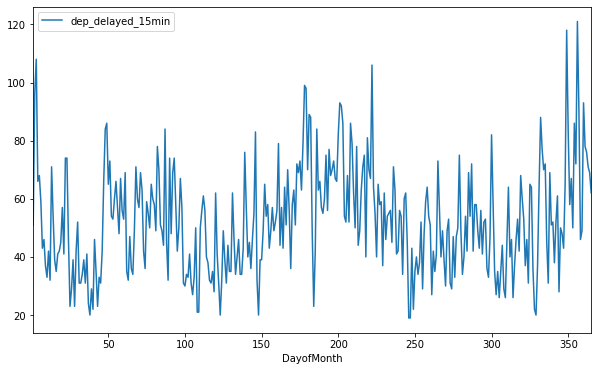

In [43]:
df5 = df[[x for x in df.columns if 'dep_delayed_15min' in x] + ['DayofMonth']]
df5.groupby('DayofMonth').sum().plot()

In [44]:
def dadada(val):
    if val <= 2400:
        g= df['DepTime'] = np.ceil(val/600)
        return g
    else:
        f = df['DepTime'] = np.round(val/600)
        return f
%time df['DepTime'] = df['DepTime'].apply(lambda x: round(dadada(x)),0)

Wall time: 41.7 s


In [45]:
Delay_vs_Day_of_Week = pd.DataFrame({'delays' : df.groupby(['DayOfWeek'])['dep_delayed_15min'].mean()}).reset_index()
Delay_vs_WEEK = pd.DataFrame({'delays' : df.groupby(['WEEK'])['dep_delayed_15min'].mean()}).reset_index()
Delay_vs_AIRLINE = pd.DataFrame({'delays' : df.groupby(['UniqueCarrier'])['dep_delayed_15min'].mean()})
Delay_vs_SCHEDULED_DEPARTURE = pd.DataFrame({'delays' : df.groupby(['DepTime'])['dep_delayed_15min'].mean()}).reset_index()

[Text(0, 0, '00:00 - 06:00'),
 Text(0, 0, '06:00 - 12:00'),
 Text(0, 0, '12:00 - 18:00'),
 Text(0, 0, '18:00 - 00:00')]

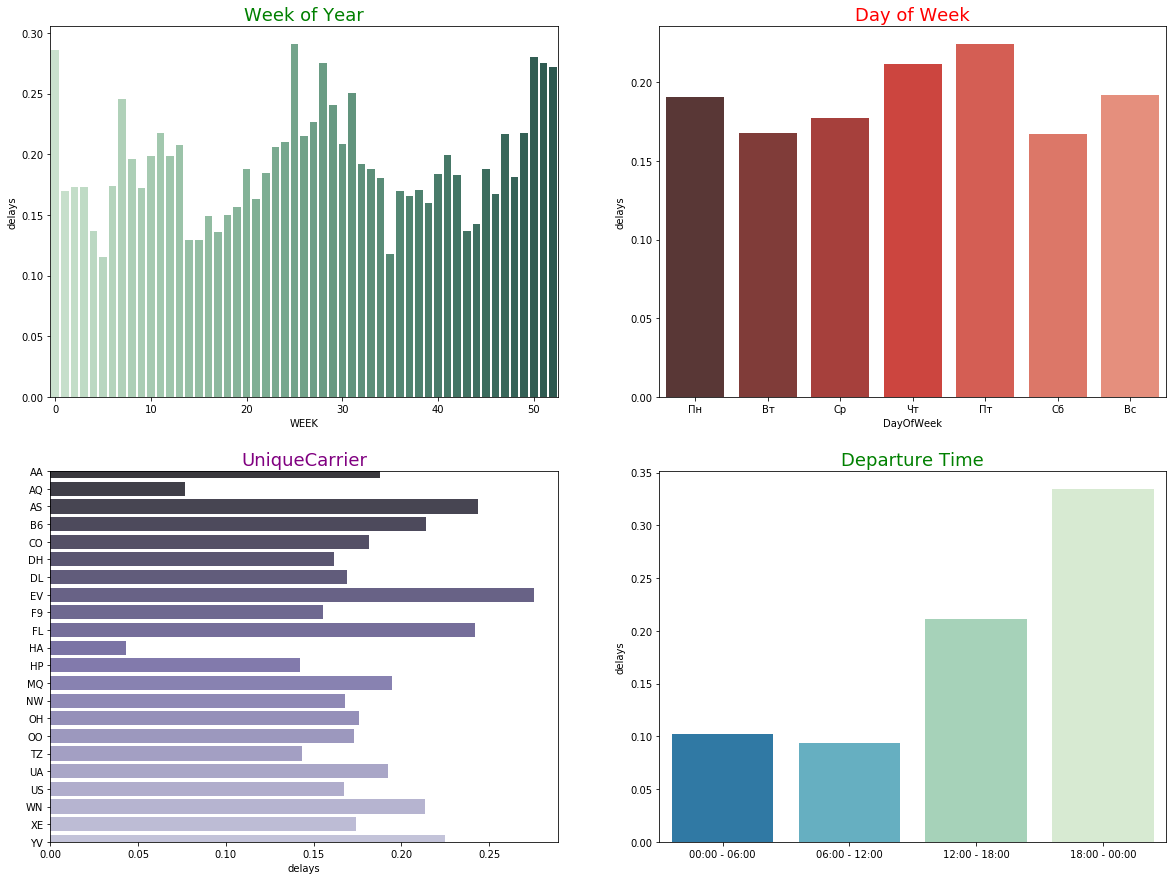

In [46]:
fig = plt.figure(figsize=(20, 15))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('Week of Year', fontsize=18, color="green")
sns.barplot(x="WEEK", y="delays", data=Delay_vs_WEEK, palette="ch:2.5,-.2,dark=.3", ax = sub1)
sub1.set_xticks(list(range(0,52,10)))
sub1.set_xticklabels(list(range(0,52,10)))

sub2 = fig.add_subplot(222)
sub2.set_title('Day of Week', fontsize=18, color="red")
sns.barplot(x="DayOfWeek", y="delays", data=Delay_vs_Day_of_Week, palette="Reds_d", ax = sub2)
sub2.set_xticklabels(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])

sub3 = fig.add_subplot(223)
sub3.set_title('UniqueCarrier', fontsize=18, color="purple")
sns.barplot(y = list(range(len(Delay_vs_AIRLINE))), x=Delay_vs_AIRLINE['delays'], palette="Purples_d", ax = sub3, orient="h")
sub3.set_yticks(range(len(Delay_vs_AIRLINE)))
sub3.set_yticklabels(Delay_vs_AIRLINE.index)

sub4 = fig.add_subplot(224)
sns.barplot(x = list(range(len(Delay_vs_SCHEDULED_DEPARTURE))), y=Delay_vs_SCHEDULED_DEPARTURE['delays'], palette="GnBu_r", ax = sub4)
sub4.set_title('Departure Time', fontsize=18, color="green")
sub4.set_xticks([0, 1, 2, 3])
sub4.set_xticklabels(['00:00 - 06:00','06:00 - 12:00','12:00 - 18:00','18:00 - 00:00'])

In [47]:
df2_delay   = df2[df2.dep_delayed_15min==True]
df2_nodelay = df2[df2.dep_delayed_15min==False]

Wall time: 1min


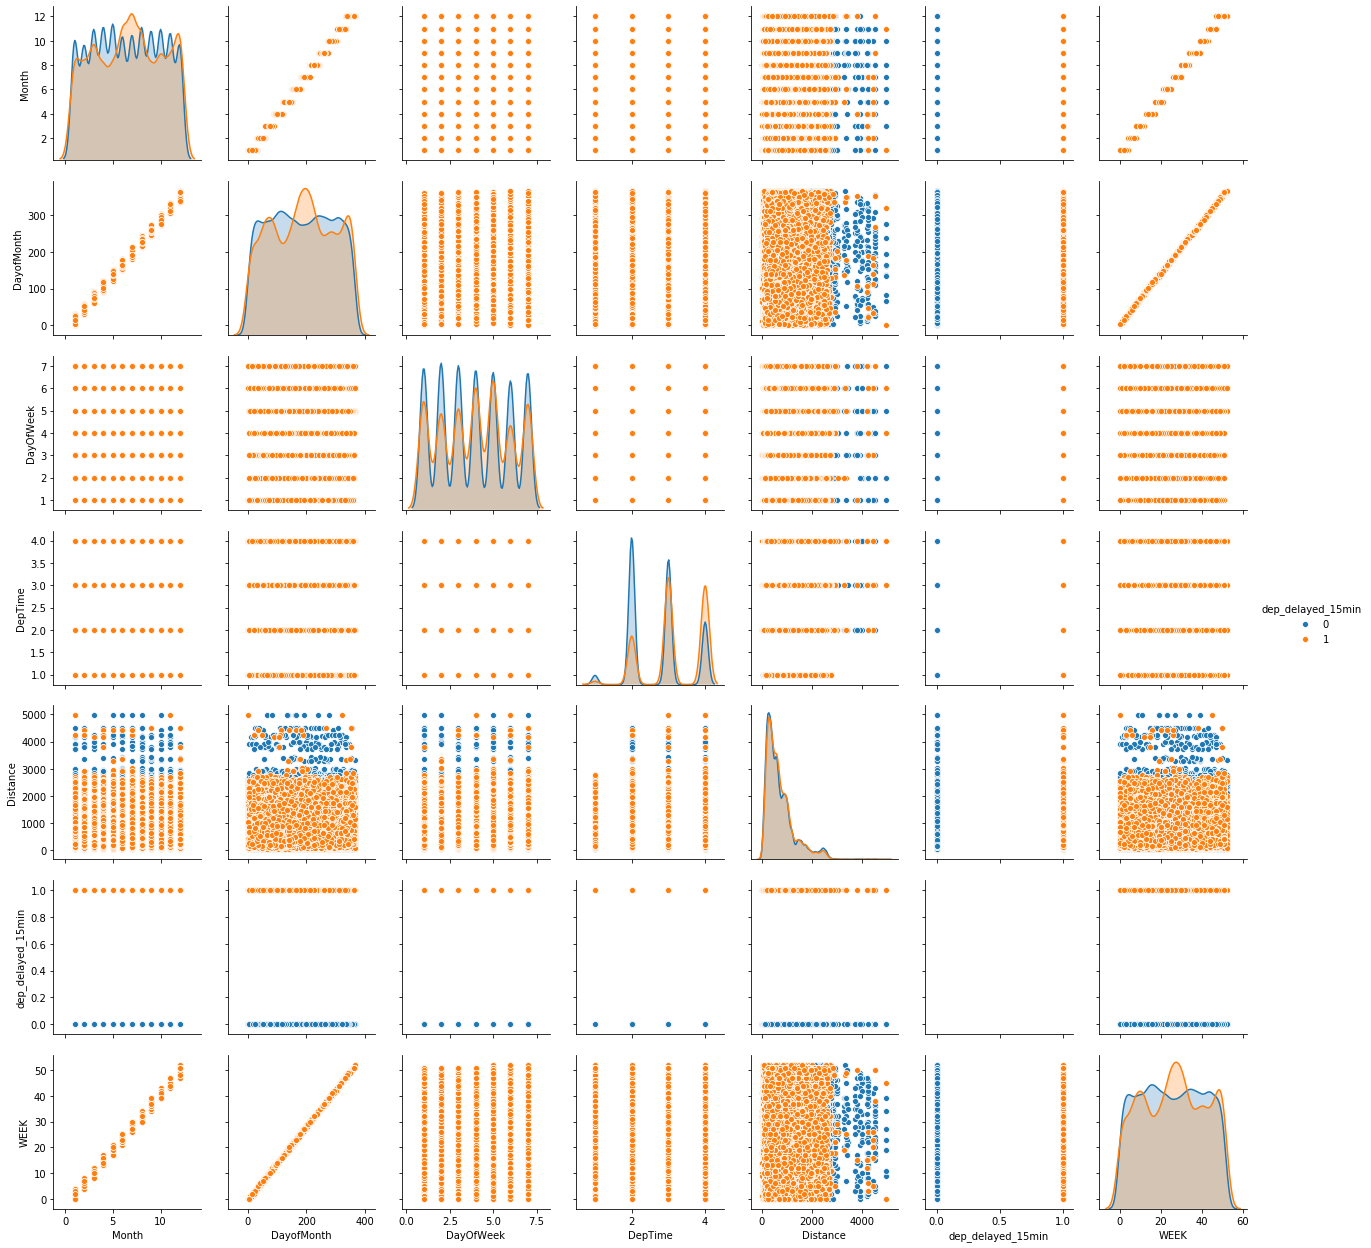

In [48]:
%time sns.pairplot(df, hue='dep_delayed_15min')